In [160]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import resample

# Loading Dataset
df = pd.read_csv('data/predictive_maintenance.csv')

## Feedforward Neural Network (Supervised)

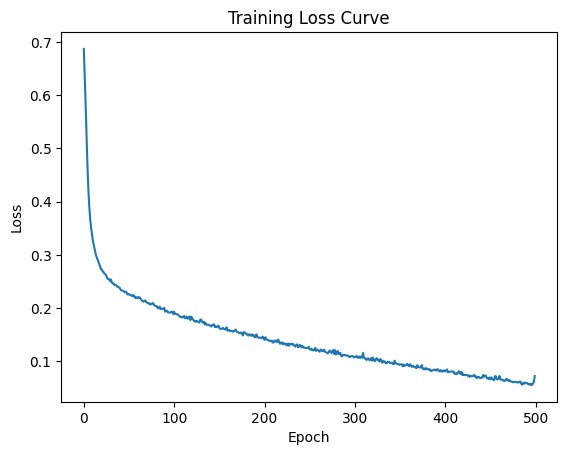

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Separate features and target
X = df.drop(columns=['UDI', 'Product ID', 'Type', 'Target', 'Failure Type'])
y = df['Target']

# Combine features and target for balanced sampling 
df_balanced = pd.concat([X, y], axis=1)

# Separate the minority (failures) and majority (non-failures) classes
failures = df_balanced[df_balanced['Target'] == 1]
non_failures = df_balanced[df_balanced['Target'] == 0]

# Downsample the majority class (non-failures)
non_failures_downsampled = resample(non_failures, replace=False, n_samples=len(failures), random_state=42)

# Combine the downsampled non-failures and failures into a balanced dataset
df_balanced = pd.concat([failures, non_failures_downsampled])

X_balanced = df_balanced.drop(columns=['Target'])
y_balanced = df_balanced['Target']

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_balanced = scaler.fit_transform(X_balanced)
X_test = scaler.transform(X)  # Normalize the full test set

# Train-test split (use the balanced dataset for training)
X_train, _, y_train, _ = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=0)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

# Define DataLoaders
batch_size = 16
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
learning_rate = 0.0005

model = FeedForwardNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
num_epochs = 500
loss_values = []

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        preds = model(batch_X)
        loss = loss_fn(preds, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Keep track of loss
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}', end='\r')

# Plot loss curve
plt.plot(loss_values)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [162]:
# Evaluation
threshold = 0.95
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        preds = model(batch_X).squeeze()
        predicted_labels = (preds > threshold).float()
        predictions.extend(predicted_labels.cpu().numpy())
        true_labels.extend(batch_y.cpu().numpy())

# Calculate metrics
precision = precision_score(true_labels, predictions, zero_division=1)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
conf_matrix = confusion_matrix(true_labels, predictions)

print(f'\nPrecision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Precision: 0.4279
Recall: 0.8496
F1-Score: 0.5692
Confusion Matrix:
[[9276  385]
 [  51  288]]
